# Test notebook 
Test the model called by wandb. 


In [28]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from earlyrnn import EarlyRNN
import torch
from utils.losses.early_reward_loss import EarlyRewardLoss
import pandas as pd
import pickle 
import wandb
import json
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_testing import test_dataset, get_test_stats, 
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs, plot_confusion_matrix, plot_probability_stopping
from models.model_helpers import count_parameters

In [2]:
import argparse

def parse_args(args=None):
    def int_list(value):
        # This function will split the string by spaces and convert each to an integer
        return [int(i) for i in value.split()]
    
    parser = argparse.ArgumentParser(description='Run ELECTS Early Classification training on the BavarianCrops dataset.')
    parser.add_argument('--backbonemodel', type=str, default="LSTM", choices=["LSTM", "TempCNN", "Transformer"], help="backbone model")
    parser.add_argument('--dataset', type=str, default="bavariancrops", choices=["bavariancrops","breizhcrops", "ghana", "southsudan","unitedstates"], help="dataset")
    parser.add_argument('--alpha', type=float, default=0.5, help="trade-off parameter of earliness and accuracy (eq 6): "
                                                                 "1=full weight on accuracy; 0=full weight on earliness")
    parser.add_argument('--epsilon', type=float, default=10, help="additive smoothing parameter that helps the "
                                                                  "model recover from too early classifications (eq 7)")
    parser.add_argument('--learning-rate', type=float, default=1e-3, help="Optimizer learning rate")
    parser.add_argument('--weight-decay', type=float, default=0, help="weight_decay")
    parser.add_argument('--patience', type=int, default=30, help="Early stopping patience")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        choices=["cuda", "cpu"], help="'cuda' (GPU) or 'cpu' device to run the code. "
                                                     "defaults to 'cuda' if GPU is available, otherwise 'cpu'")
    parser.add_argument('--epochs', type=int, default=100, help="number of training epochs")
    parser.add_argument('--sequencelength', type=int, default=70, help="sequencelength of the time series. If samples are shorter, "
                                                                "they are zero-padded until this length; "
                                                                "if samples are longer, they will be undersampled")
    parser.add_argument('--extra-padding-list', type=int_list, default=[[0]], nargs='+', help="extra padding for the TempCNN model")
    parser.add_argument('--hidden-dims', type=int, default=64, help="number of hidden dimensions in the backbone model")
    parser.add_argument('--batchsize', type=int, default=256, help="number of samples per batch")
    parser.add_argument('--dataroot', type=str, default=os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data"), help="directory to download the "
                                                                                 "BavarianCrops dataset (400MB)."
                                                                                 "Defaults to home directory.")
    parser.add_argument('--snapshot', type=str, default="snapshots/model.pth",
                        help="pytorch state dict snapshot file")
    parser.add_argument('--resume', action='store_true')

    if args is not None:
        args = parser.parse_args(args)
    else:
        args = parser.parse_args()

    if args.patience < 0:
        args.patience = None
    args.extra_padding_list = [item for sublist in args.extra_padding_list for item in sublist]

    return args


custom_args = "--dataset breizhcrops --snapshot ./models/breizhcrops_models/elects_lstm/model.pth --sequencelength 150".split()
args = parse_args(custom_args)
print("cuda is available: ", args.device)
print(args)

cuda is available:  cuda
Namespace(backbonemodel='LSTM', dataset='breizhcrops', alpha=0.5, epsilon=10, learning_rate=0.001, weight_decay=0, patience=30, device='cuda', epochs=100, sequencelength=150, extra_padding_list=[0], hidden_dims=64, batchsize=256, dataroot='C:\\Users\\anyam\\elects_data', snapshot='./models/breizhcrops_models/elects_lstm/model.pth', resume=False)


## Download the model from wandb 

In [3]:
api = wandb.Api()
entity, project = "aurenore", "MasterThesis"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)
runs_df

,summary,config,name
0,"{'loss': {'testloss': 5.605116367340088, 'trai...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",distinctive-pyramid-28
1,"{'fscore': 0.32329864376870143, 'harmonic_mean...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",valiant-planet-27
2,"{'conf_mat_table': {'nrows': 81, 'sha256': 'e8...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",twilight-waterfall-26
3,"{'loss': {'testloss': 3.583357810974121, 'trai...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",zany-energy-23
4,"{'loss': {'testloss': 3.6518073081970215, 'tra...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",ELECTS-TempCNN-hd16
5,"{'fscore': 0.5410980634951035, 'harmonic_mean'...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",ELECTS-TempCNN-hd64
6,"{'loss': {'testloss': 3.5096075534820557, 'tra...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",ELECTS-TempCNN-hd32
7,"{'loss': {'testloss': 4.522304058074951, 'trai...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",TempCNN-seqlength150
8,"{'precision': 0.5762538573509405, '_timestamp'...","{'alpha': 0.5, 'device': 'cpu', 'epochs': 100,...",LSTM-seqlength150
9,"{'_step': 87, 'recall': 0.5396733655543473, 'h...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",TempCNN-seqlength70


In [4]:
# get the df with name containing "TempCNN-padding"
df = runs_df[runs_df["name"].str.contains("ELECTS-TempCNN")]
# get the chosen_run with the highest harmonic_mean
chosen_run_idx = df["summary"].apply(lambda x: x["harmonic_mean"]).idxmax()
chosen_run = runs[chosen_run_idx]
chosen_run_config = chosen_run.config
print("chosen run name: ", chosen_run.name)


chosen run name:  ELECTS-TempCNN-hd32


In [20]:
chosen_run_name = "ELECTS-TempCNN-hd32"
# get the corresponding run from runs (not the dataframe, the actual run)
# if list index out of rang error, check if the run name is correct
if chosen_run_name not in runs_df.name.values:
    raise ValueError(f"Run {chosen_run_name} not found in the dataframe")
chosen_run = [run for run in runs if run.name == chosen_run_name][0]
chosen_run_config = chosen_run.config

In [22]:
artifacts = chosen_run.logged_artifacts()
model = [artifact for artifact in artifacts if artifact.type == "model"][-1] # get the latest model artifact
model_path = model.download()
print(model_path)

# save config as json file
with open(os.path.join(model_path,"config.json"), "w") as f:
    json.dump(chosen_run_config, f)

wandb:   1 of 1 files downloaded.  


c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-j4jl19vf-model.pth-v5


## Test.py - Test the model



In [7]:
# ----------------------------- LOAD DATASET -----------------------------
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    nclasses = 9
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=args.sequencelength, return_id=True)
    class_names = test_ds.ds.classname
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:54<00:00, 2266.45it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


In [23]:
# ----------------------------- LOAD MODEL -----------------------------
# if no "hidden_dims" in chosen_run_config, use 64
if "hidden_dims" not in chosen_run_config:
    chosen_run_config["hidden_dims"] = 64
if "backbonemodel" not in chosen_run_config:
    chosen_run_config["backbonemodel"] = "LSTM"
if args.hidden_dims != chosen_run_config["hidden_dims"]:
    print(f"Warning: hidden_dims argument {args.hidden_dims} does not match the chosen run's hidden_dims {chosen_run_config['hidden_dims']}. Using the latter.")
    args.hidden_dims = chosen_run_config["hidden_dims"]
if args.sequencelength != chosen_run_config["sequencelength"]:
    print(f"Warning: sequencelength argument {args.sequencelength} does not match the chosen run's sequencelength {chosen_run_config['sequencelength']}. Using the first.")
if args.backbonemodel != chosen_run_config["backbonemodel"]:
    print(f"Warning: backbonemodel argument {args.backbonemodel} does not match the chosen run's backbonemodel {chosen_run_config['backbonemodel']}. Using the latter.")
    args.backbonemodel = chosen_run_config["backbonemodel"]
if args.extra_padding_list != chosen_run_config["extra_padding_list"]:
    print(f"Warning: extra_padding_list argument {args.extra_padding_list} does not match the chosen run's extra_padding_list {chosen_run_config['extra_padding_list']}. Using the latter.")
    args.extra_padding_list = chosen_run_config["extra_padding_list"]

# ----------------------------- LOAD MODEL -----------------------------
model = EarlyRNN(backbone_model=args.backbonemodel, nclasses=nclasses, input_dim=input_dim, hidden_dims=args.hidden_dims, sequencelength=args.sequencelength).to(args.device)
print("model is loading from: ", model_path)
model.load_state_dict(torch.load(os.path.join(model_path, "model.pth")))
criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon)
print(f"The model has {count_parameters(model):,} trainable parameters.")



model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-j4jl19vf-model.pth-v5
The model has 31,204 trainable parameters.


Extracting labels from dataset Test.


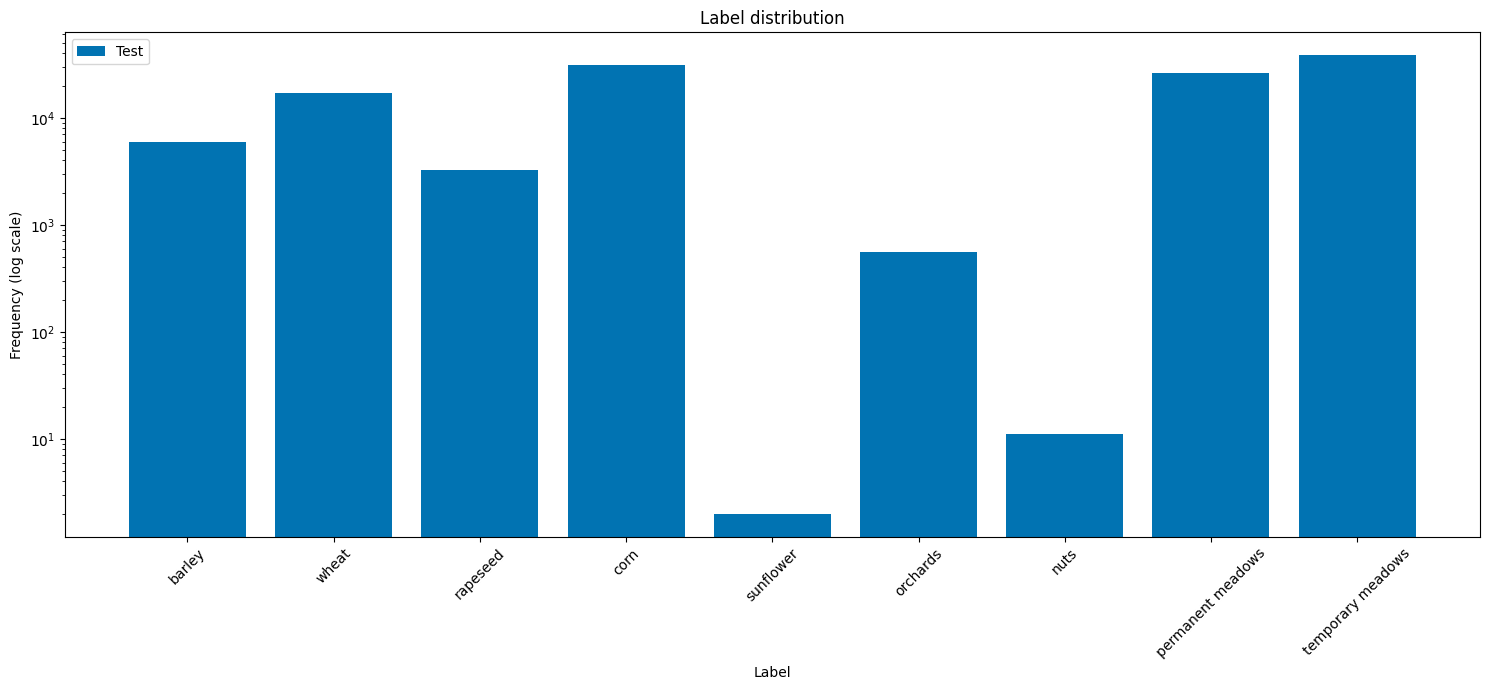

In [4]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

## Test the model with the test dataset

In [26]:
# ----------------------------- TEST -----------------------------
# if the files do not exist, they will be created
if os.path.exists(os.path.join(model_path, "testloss.pkl")) and os.path.exists(os.path.join(model_path, "stats.pkl")):
    print("testloss.pkl and stats.pkl exist. Loading them.")
    with open(os.path.join(model_path, "testloss.pkl"), "rb") as f:
        testloss = pickle.load(f)
    with open(os.path.join(model_path, "stats.pkl"), "rb") as f:
        stats = pickle.load(f)
else: 
    print("testloss.pkl or stats.pkl does not exist. Running test.")
    testloss, stats = test_dataset(model, test_ds, criterion, args.device, args.batchsize, extra_padding_list=args.extra_padding_list, return_id=test_ds.return_id)

    # with open(os.path.join(model_path, "testloss.pkl"), "wb") as f:
    #     pickle.dump(testloss, f)
    # print("test loss saved to", os.path.join(model_path, "testloss.pkl"))

    # with open(os.path.join(model_path, "stats.pkl"), "wb") as f:
    #     pickle.dump(stats, f)
    # print("stats saved to", os.path.join(model_path, "stats.pkl"))
    
test_stats = get_test_stats(stats, testloss, args, nclasses)

testloss.pkl or stats.pkl does not exist. Running test.


## Graphs

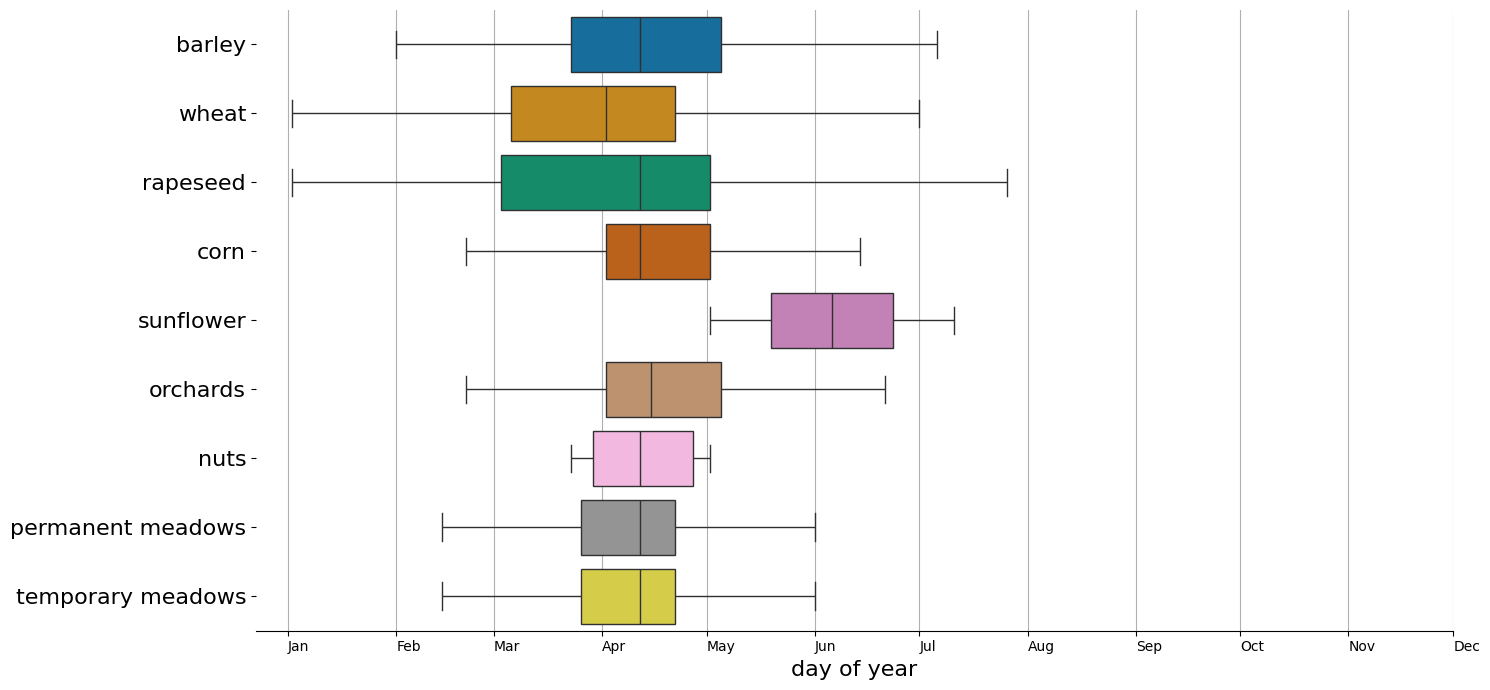

In [27]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))

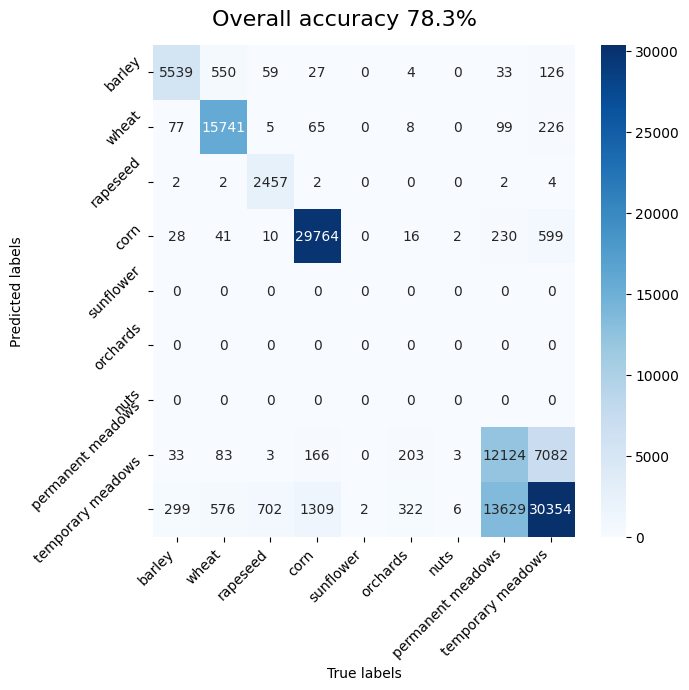

In [29]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_confusion_matrix(stats["targets"][:, 0], stats["predictions_at_t_stop"].flatten(), class_names, fig, ax)
fig.savefig(os.path.join(model_path, "confusion_matrix.png"))

(<Figure size 600x400 with 1 Axes>, <Axes: >)

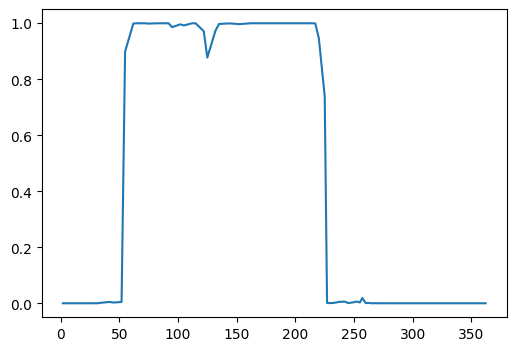

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
plot_doy_prob(6052609, stats, doys_dict_test, model, args.device, test_ds, fig, ax)

for class 0 we have 500 samples
for class 1 we have 500 samples
for class 2 we have 500 samples
for class 3 we have 500 samples
for class 4 we have 2 samples
for class 5 we have 500 samples
for class 6 we have 11 samples
for class 7 we have 500 samples
for class 8 we have 500 samples


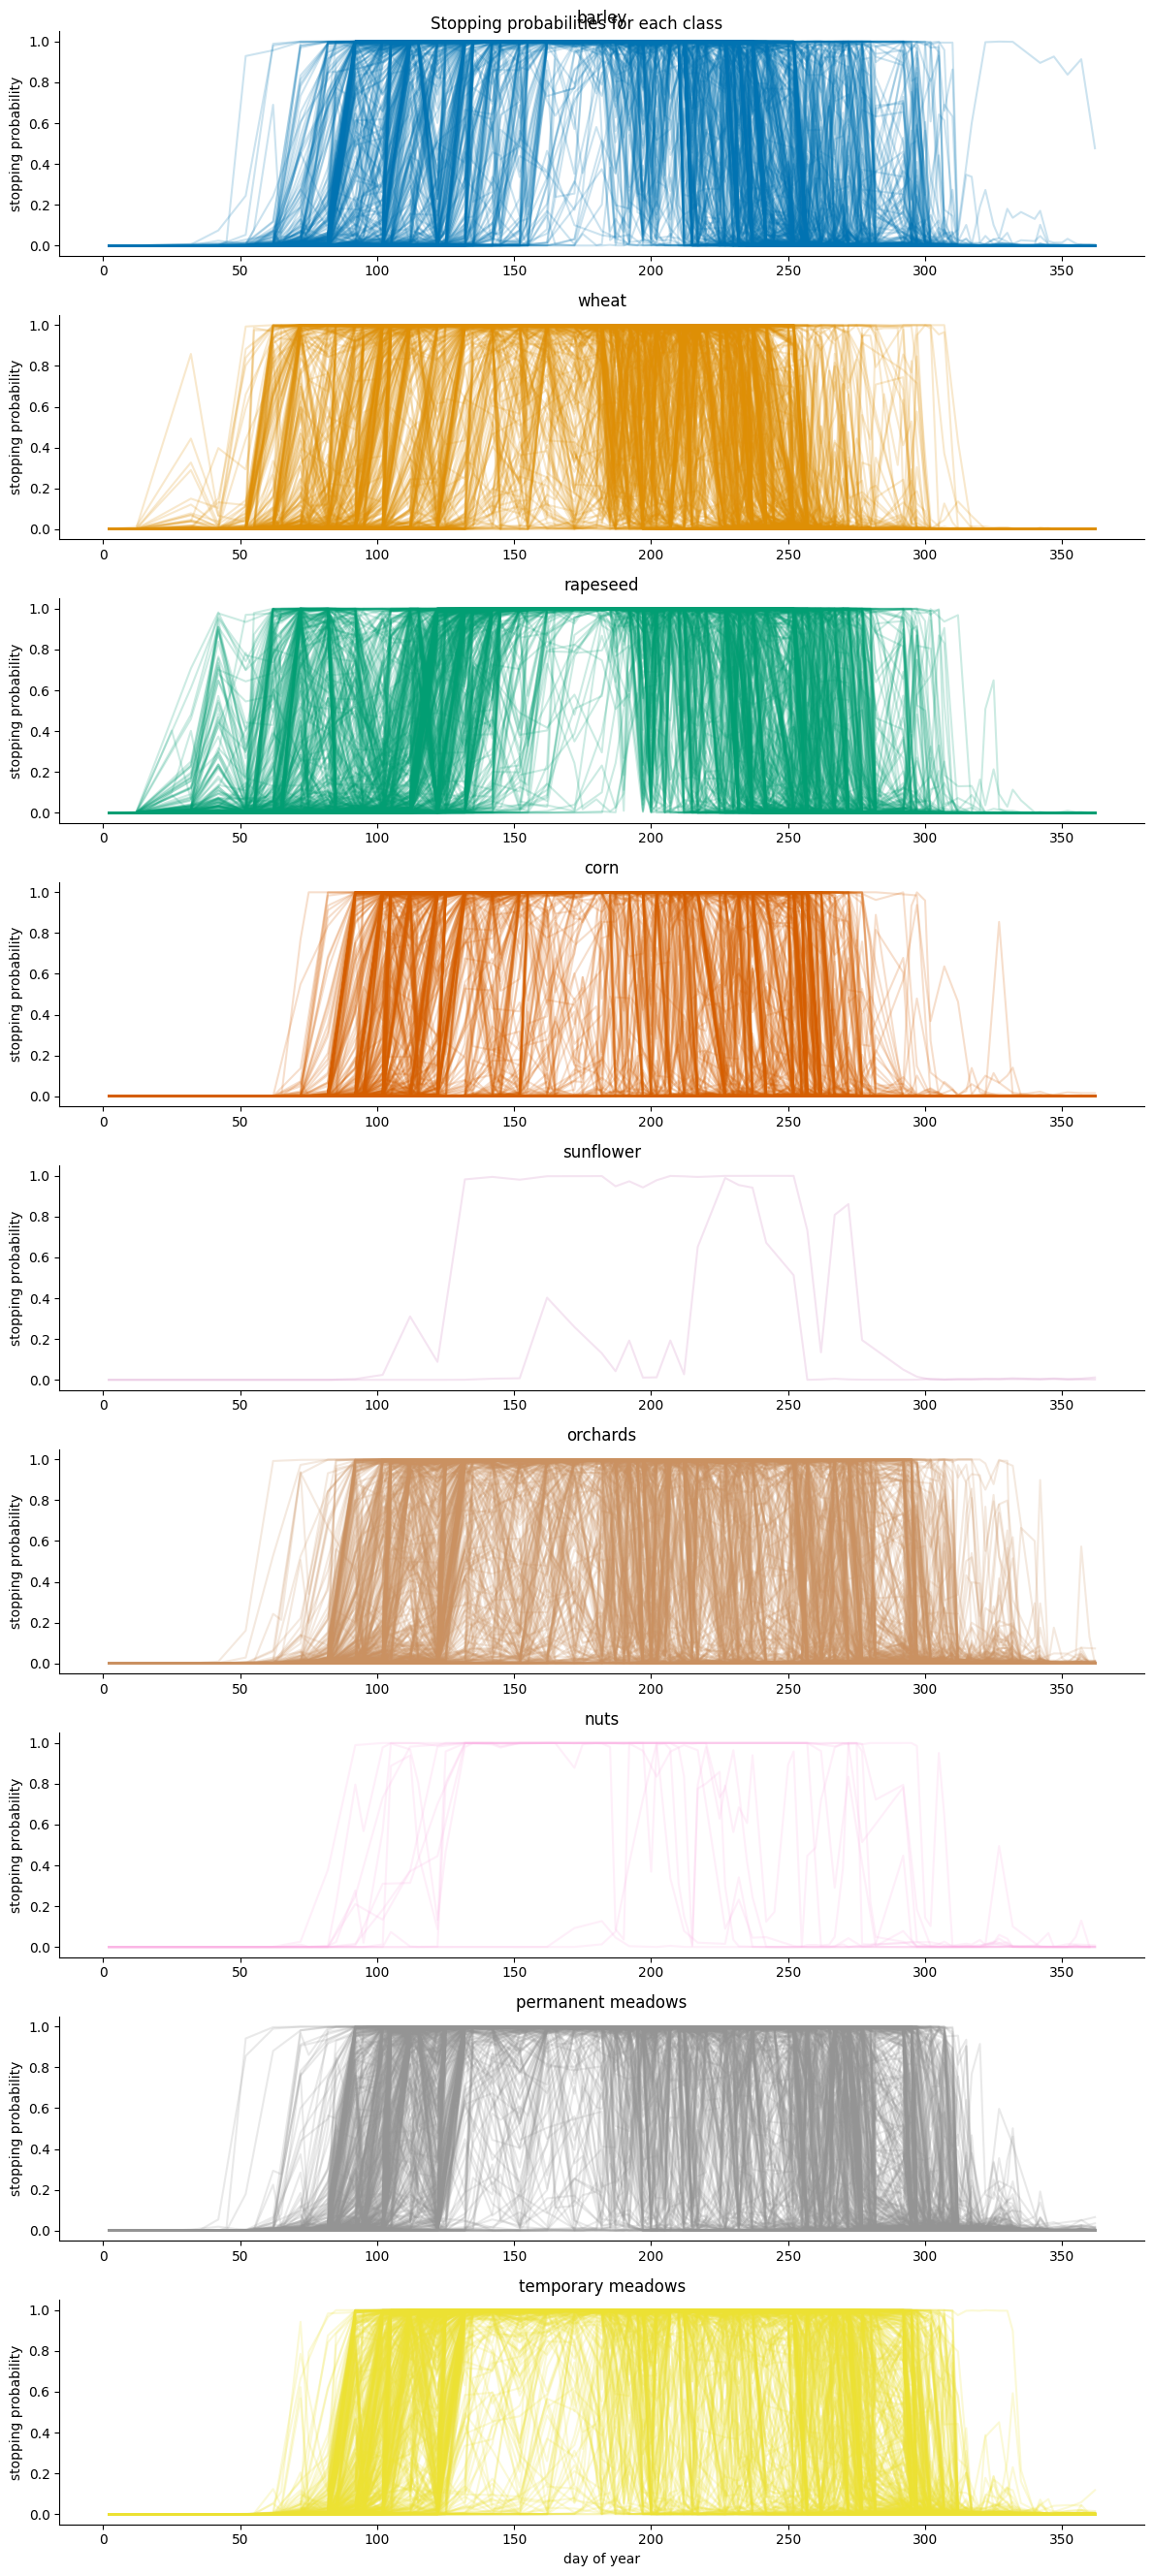

In [31]:
fig, axes = plot_all_doy_probs(stats, doys_dict_test, nclasses=nclasses, class_names=class_names, alpha=0.2, nsamples=500)
fig.savefig(os.path.join(model_path, "doy_probs.png"))

## Analyse the probability of stopping

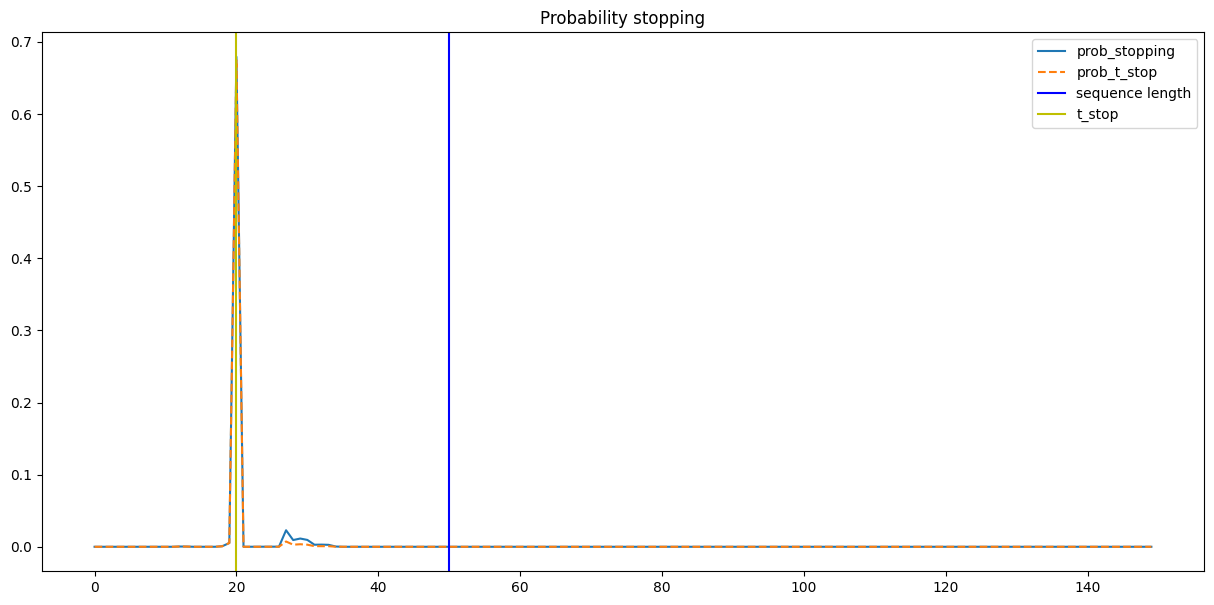

In [39]:
# plot the probability stopping 
fig, ax = plt.subplots(figsize=(15, 7))
index = -1
ax = plot_probability_stopping(stats, index, ax)

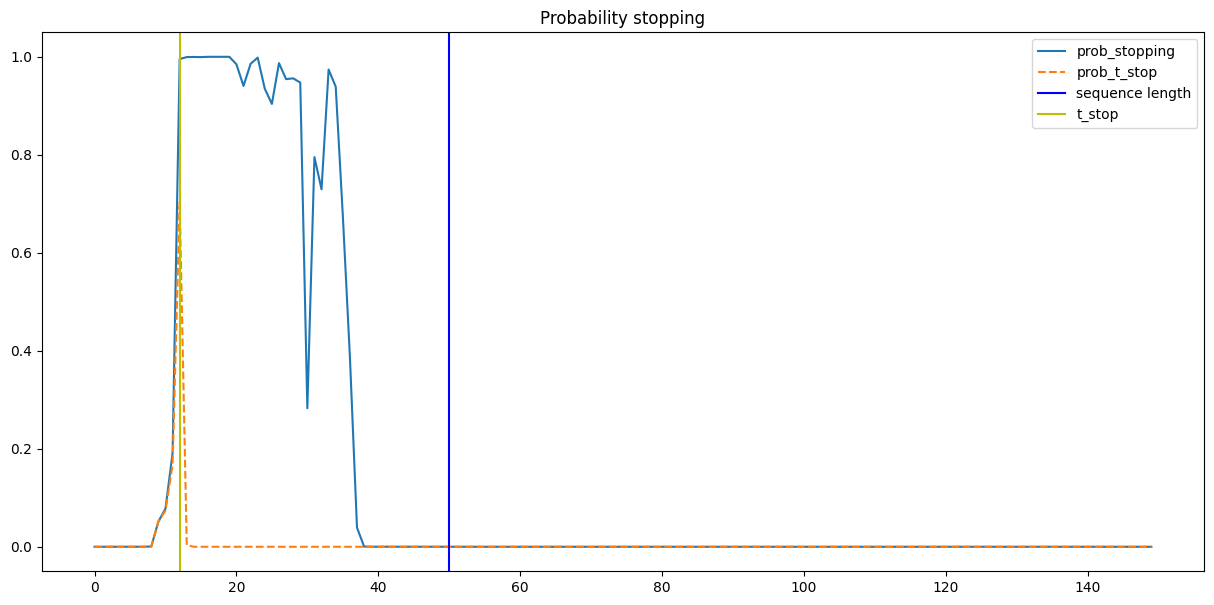

In [40]:
# plot the probability stopping 
fig, ax = plt.subplots(figsize=(15, 7))
index = -5
ax = plot_probability_stopping(stats, index, ax)